### This notebook generates the moisture-precip relationships for MCSs in the idealized RCE simulations.

In [1]:
import numpy as np
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# colorblind friendly colormap
CB_color_cycle = [ '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00']

## Loading RCE data

In [15]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
ssts = np.arange( 285, 316, 5 )

mean_285 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_MEAN_285.nc' )
mean_290 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_MEAN_290.nc' )
mean_295 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_MEAN_295.nc' )
mean_300 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_MEAN_300.nc' )
mean_305 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_MEAN_305.nc' )
mean_310 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_MEAN_310.nc' )

p99_285 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_99_285.nc' )
p99_290 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_99_290.nc' )
p99_295 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_99_295.nc' )
p99_300 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_99_300.nc' )
p99_305 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_99_305.nc' )
p99_310 = xr.open_dataset( '/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_99_310.nc' )

In [16]:
clusters_285 = xr.open_dataset('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_cluster-sizes_285.nc' )
clusters_290 = xr.open_dataset('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_cluster-sizes_290.nc' )
clusters_295 = xr.open_dataset('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_cluster-sizes_295.nc' )
clusters_300 = xr.open_dataset('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_cluster-sizes_300.nc' )
clusters_305 = xr.open_dataset('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_cluster-sizes_305.nc' )
clusters_310 = xr.open_dataset('/xdisk/sylvia/RCE-CAPE-exploration/RCE_COL_cluster-sizes_310.nc' )
clusters = [clusters_300, clusters_305, clusters_310]
rad = []

for c in clusters:
    rad.append( 2*(c['cluster_sizes']*9/np.pi)**(0.5) )

### Comparing MCS size between RCE and ERA-I datasets

In [4]:
years = np.arange( 1983, 2008 )
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
maxlat_array = nc_open_compile(file_years,"max latitude")
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]

rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_indx]

[153.82352941]
[144.70588235]
[162.94117647]
[172.05882353]
[181.17647059]
[199.41176471]
[199.41176471]


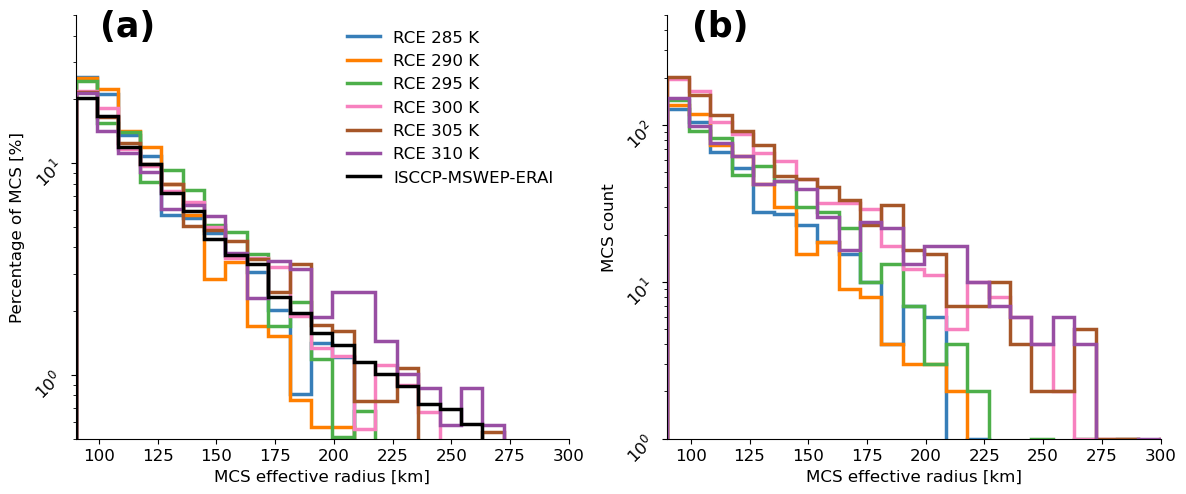

In [5]:
nbin=35
let = ['(a)', '(b)']
clusters = [clusters_285, clusters_290, clusters_295, clusters_300, clusters_305, clusters_310]

fig, ax = plt.subplots( 1, 2, figsize=(14, 5.5) )
for i, c in enumerate(clusters):
    rad = 2*(c['cluster_sizes']*9/np.pi)**(0.5)
    h, edges = np.histogram( rad, bins=np.linspace(90, 400, nbin) )
    wgts = np.ones_like( rad ) / float(len( rad ))*100
    h2, edges2 = np.histogram( rad, bins=np.linspace(90, 400, nbin), weights=wgts)
    j = np.argwhere( np.cumsum(h2) > 90 )[0]
    #print(np.cumsum(h2))
    print(edges2[j]) #At which MCS size, do we exceed the 90th percentile?
    ax[1].stairs( h, edges, edgecolor=CB_color_cycle[i], lw=2.5 )
    ax[0].stairs( h2, edges2, edgecolor=CB_color_cycle[i], lw=2.5, label='RCE ' + str(ssts[i]) +' K'  )

wgts = np.ones_like( rad_ERAI ) / float(len( rad_ERAI ))*100
h, edges = np.histogram( rad_ERAI, bins=np.linspace(90, 400, nbin), weights=wgts )
ax[0].stairs( h, edges, edgecolor='k', lw=2.5, label='ISCCP-MSWEP-ERAI', zorder=10 )
j = np.argwhere( np.cumsum(h) > 90 )[0]
#print(np.cumsum(h))
print(edges[j]) #At which MCS size, do we exceed the 90th percentile?
    
for i, a in enumerate(ax):
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    a.set_xlabel( r'MCS effective radius [km]' )
    a.set_xlim( [90, 300] )
    a.set_yscale( 'log' )
    a.tick_params( axis='y', rotation=45 )
    a.text( 0.05, 0.95, let[i], weight='bold', fontsize=25, transform=a.transAxes )
    
ax[1].set_ylabel( 'MCS count' )
ax[0].set_ylabel( 'Percentage of MCS [%]' )
ax[1].set_ylim( [1, 500] )
ax[0].set_ylim( [0.5, 50] )
ax[0].legend( frameon=False )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/MCS-size-distribution.pdf', bbox_inches='tight' )
plt.show()

In [6]:
print(np.linspace(90, 400, nbin))

[ 90.          99.11764706 108.23529412 117.35294118 126.47058824
 135.58823529 144.70588235 153.82352941 162.94117647 172.05882353
 181.17647059 190.29411765 199.41176471 208.52941176 217.64705882
 226.76470588 235.88235294 245.         254.11764706 263.23529412
 272.35294118 281.47058824 290.58823529 299.70588235 308.82352941
 317.94117647 327.05882353 336.17647059 345.29411765 354.41176471
 363.52941176 372.64705882 381.76470588 390.88235294 400.        ]


### CSF-precip relationship for MCS across percentiles

In [17]:
mean_RCE = [ mean_285, mean_290, mean_295, mean_300, mean_305, mean_310 ]
p99s = [ p99_285, p99_290, p99_295, p99_300, p99_305, p99_310 ]

csf_bins_list = [ [] for i in np.arange( len(mean_RCE) ) ]
pmean_list = [ [] for i in np.arange( len(mean_RCE) ) ]
perror_list = [ [] for i in np.arange( len(mean_RCE) ) ]
p99_list = [ [] for i in np.arange( len(p99s) ) ]

m_list = [ [] for i in np.arange( len(mean_RCE) ) ]
a_list = [ [] for i in np.arange( len(mean_RCE) ) ]
m_list2 = [ [] for i in np.arange( len(mean_RCE) ) ]
a_list2 = [ [] for i in np.arange( len(mean_RCE) ) ]

In [18]:
# exponential fit between CSF and precipitation
def monoexp(x, m, a):
    return m * np.exp(a * x)

In [19]:
pc2 = 99
for iterator, array in enumerate( p99s ):
    csf_RCE = array['csf'].to_numpy()
    pmean_RCE = array['p_rate'].to_numpy()

    csf_bins, pmean_vals, _, p99_vals, _, p_error, _, _ = \
        bin_stat_function( 50, 0.25, 1, csf_RCE, pmean_RCE, pc2=pc2, threshold=10 )
    
    csf_bins_list[iterator] = csf_bins
    pmean_list[iterator] = pmean_vals
    p99_list[iterator] = p99_vals
    perror_list[iterator] = p_error
    
    # fit an exponential to the mean CSF-Precip relationship and assess goodness-of-fit
    # CSF input to the curve_fit is a decimal not a percentage, hence /100.
    p0 = [ 1, 11 ]
    i = np.where( ~np.isnan(csf_bins) )
    params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., pmean_vals[i], p0 )
    m, a = params
    m_list[iterator] = m
    a_list[iterator] = a
    
    squaredDiffs = np.square(pmean_vals[i] - monoexp(csf_bins[i]/100., m, a))
    squaredDiffsFromMean = np.square(pmean_vals[i] - np.mean(pmean_vals[i]))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    print( rSquared )
    print( str(m) + ' ' + str(a) )
    
    # fit an exponential to the max CSF-Precip relationship
    p0 = [ 1, 11 ]
    i = np.where( ~np.isnan(csf_bins) )
    params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., p99_vals[i], p0 )
    m, a = params
    m_list2[iterator] = m
    a_list2[iterator] = a
    print( str(m) + ' ' + str(a) )
    print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

0.9948179686930883
1.6450542635074773e-11 3419.911186345889
1.0515673971021766e-07 2418.2024337046237
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9906934942756214
2.1336088935358425e-09 2669.3307939291426
1.4468146502456834e-05 1711.376175286536
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9956083010286898
4.3048448731921985e-09 2497.9385175398197
5.34125303805505e-06 1778.7803596718388
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9978759386398206
1.4021014694658686e-08 2319.069961375089
4.373894705539301e-05 1526.7793415923193
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9873381134197747
2.488783460350854e-06 1757.4445931956418
0.0002465604817032893 1332.4764214117154
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9738781680148163
8.656247661366924e-06 1616.700064979265
0.0018677359445893045 1120.0119479785144
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [20]:
# now combine all CSF, precipitation, and cluster size values across the three files where there is minimal SST dependence
csf_RCE = np.concatenate( (p99_300['csf'].to_numpy(), p99_305['csf'].to_numpy(), p99_310['csf'].to_numpy()), axis=0 )
pmean_RCE = np.concatenate( (p99_300['p_rate'].to_numpy(), p99_305['p_rate'].to_numpy(),
                             p99_310['p_rate'].to_numpy()), axis=0 )
rad_RCE = np.concatenate( (rad[0].to_numpy(), rad[1].to_numpy(), rad[2].to_numpy()), axis=0 )
nbin=40

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for smallest systems
csf_bins_0, pmean_vals_0, _, p99_vals_0, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csf_RCE, pmean_RCE, pc2=pc2, threshold=10 )

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for smallest systems
csf_bins_small, pmean_vals_small, _, p99_vals_small, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csf_RCE[rad_RCE < 110], pmean_RCE[rad_RCE < 110], pc2=pc2, threshold=10 )
i = np.where( ~np.isnan(csf_bins_small) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_small[i]/100, pmean_vals_small[i], p0 )
m_small, a_small = params
print(m_small,a_small)

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for larger systems
csf_bins_large, pmean_vals_large, _, p99_vals_large, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csf_RCE[rad_RCE >= 150], pmean_RCE[rad_RCE >= 150], pc2=pc2, threshold=10 )
i = np.where( ~np.isnan(csf_bins_large) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_large[i]/100, pmean_vals_large[i], p0 )
m_large, a_large = params
print(m_large,a_large)

4.235812997446196e-06 1709.0584444890349
1.141274327345865e-06 1836.7711749263701


In [21]:
print('For CSF bins for 70% or greater, how do mean and extreme precipitation shift between the smallest and largest MCSs?')
i=28
print( csf_bins_small[i:-2] )
print( np.nanmedian(pmean_vals_small[i:-2]-pmean_vals_large[i:-2]) )
print( np.nanmean(pmean_vals_small[i:-2]-pmean_vals_large[i:-2]) )
print( pmean_vals_small[i:-2]-pmean_vals_large[i:-2] )
print( '~~~~~~~~~~~~~~~~~~~~~~~~~' )
print( csf_bins_large[i:-1] )
print( np.nanmedian(p99_vals_small[i:-1]-p99_vals_large[i:-1]) )
print( np.nanmean(p99_vals_small[i:-1]-p99_vals_large[i:-1]) )
print( p99_vals_small[i:-1]-p99_vals_large[i:-1] )

For CSF bins for 70% or greater, how do mean and extreme precipitation shift between the smallest and largest MCSs?
[0.79820924 0.81726493 0.83686251 0.85561316 0.87394084 0.8956734
 0.9156275  0.93333868 0.9532341  0.96802754]
1.6744295323088352
2.6887086856261275
[ 0.24187072  0.87772184  1.27369386  4.47807508  3.0300816  -1.87752017
 10.71973514  4.79456972  1.77059928  1.57825978]
~~~~~~~~~~~~~~~~~~~~~~~~~
[0.79905551 0.81586458 0.83558116 0.85630034 0.87584415 0.89581968
 0.91455522 0.93310688 0.95494921 0.96834194 0.9902272 ]
12.073693382379403
12.627627579595895
[ 7.47670243 11.01596202  0.77248606 19.80611928 12.07369338 -5.63560919
 40.92393729 15.68789224 17.11108571  4.34197865 15.3296555 ]


### CSF-precip relationship for MCS across portions of the column

In [52]:
csfBL_RCE = np.concatenate( (p99_300['csf_BL'].to_numpy(), p99_305['csf_BL'].to_numpy(), p99_310['csf_BL'].to_numpy()), axis=0 )
csfTROP1_RCE = np.concatenate( (p99_300['csf_TROP1'].to_numpy(), p99_305['csf_TROP1'].to_numpy(), p99_310['csf_TROP1'].to_numpy()), axis=0 )
csfTROP2_RCE = np.concatenate( (p99_300['csf_TROP2'].to_numpy(), p99_305['csf_TROP2'].to_numpy(), p99_310['csf_TROP2'].to_numpy()), axis=0 )
csfTROP3_RCE = np.concatenate( (p99_300['csf_TROP3'].to_numpy(), p99_305['csf_TROP3'].to_numpy(), p99_310['csf_TROP3'].to_numpy()), axis=0 )
pmean_RCE = np.concatenate( (p99_300['p_rate'].to_numpy(), p99_305['p_rate'].to_numpy(),
                             p99_310['p_rate'].to_numpy()), axis=0 )
rad_RCE = np.concatenate( (rad[0].to_numpy(), rad[1].to_numpy(), rad[2].to_numpy()), axis=0 )
nbin=40

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for different strata
csf_bins_BL, pmean_vals_BL, _, p99_vals_BL, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csfBL_RCE, pmean_RCE, pc2=pc2, threshold=10 )
csf_bins_TROP1, pmean_vals_TROP1, _, p99_vals_TROP1, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csfTROP1_RCE, pmean_RCE, pc2=pc2, threshold=10 )
csf_bins_TROP2, pmean_vals_TROP2, _, p99_vals_TROP2, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csfTROP2_RCE, pmean_RCE, pc2=pc2, threshold=10 )
csf_bins_TROP3, pmean_vals_TROP3, _, p99_vals_TROP3, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csfTROP3_RCE, pmean_RCE, pc2=pc2, threshold=10 )

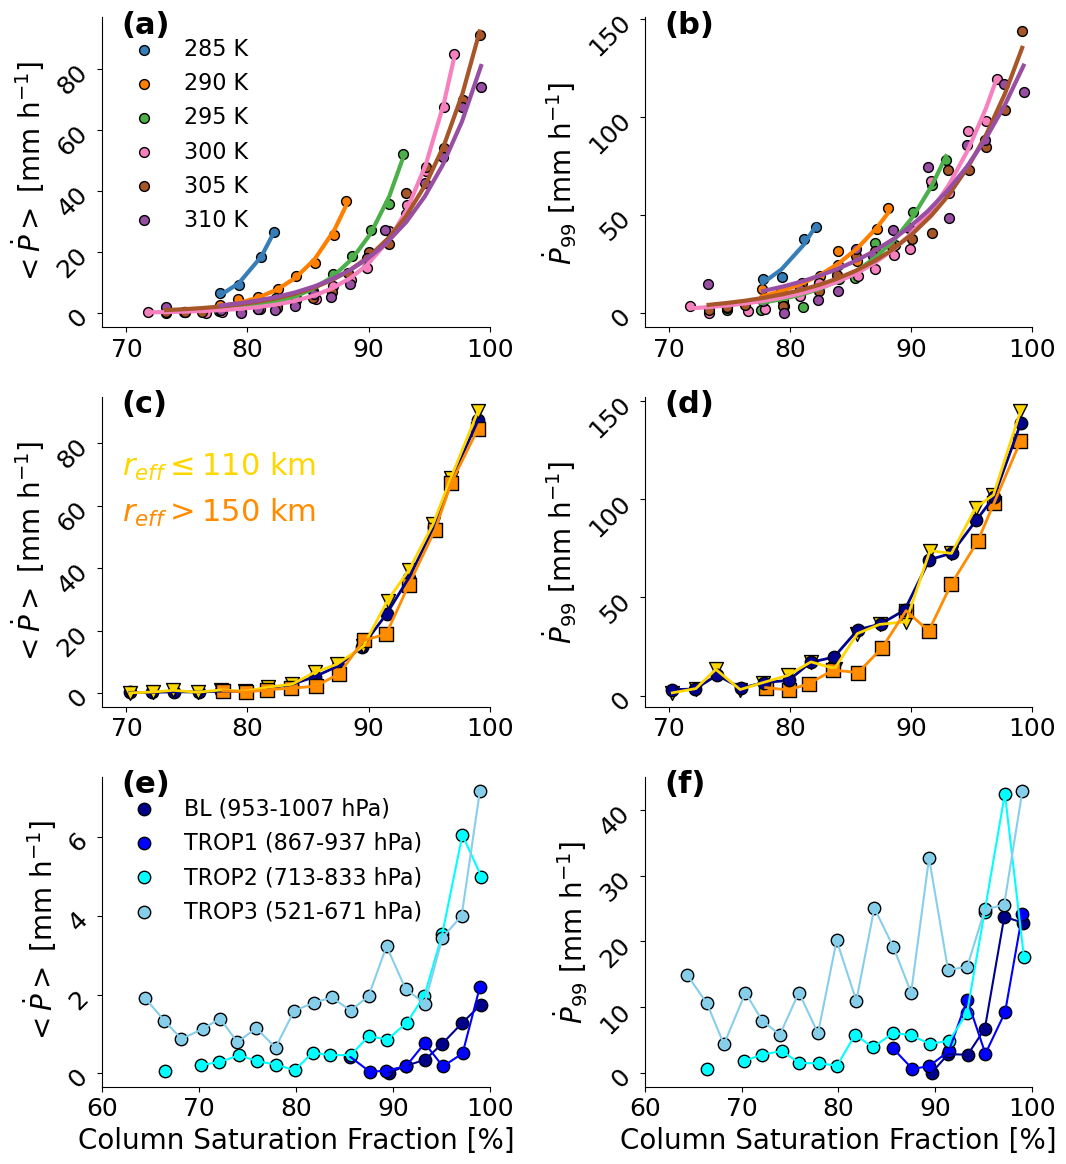

In [55]:
fig, ax = plt.subplots( 3, 2, figsize =(11, 12) )

ylab = [ r'$<\dot{P}>$ [mm h$^{-1}$]', r'$\dot{P}_{99}$ [mm h$^{-1}$]', r'$<\dot{P}>$ [mm h$^{-1}$]',
        r'$\dot{P}_{99}$ [mm h$^{-1}$]', r'$<\dot{P}>$ [mm h$^{-1}$]', r'$\dot{P}_{99}$ [mm h$^{-1}$]' ]
xlab = [ '', '', '', '', 'Column Saturation Fraction [%]', 'Column Saturation Fraction [%]' ]
font_size = 18
fs = 22
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size-2,
})

for i, axis in enumerate(ax.flatten()): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [68, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = xlab[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        for j, k, l, m, n, o in zip(csf_bins_list, pmean_list, np.arange(len(csf_bins_list)), perror_list, m_list, a_list):
            y = monoexp( j/100, n, o )
            axis.plot( j*100, y, lw=3, color=CB_color_cycle[l], zorder=10 )
            axis.scatter( j*100, k, color = CB_color_cycle[l], s=50, edgecolor='black', label=str(ssts[l])+' K'  )
            #axis.errorbar( j, k, xerr=None, yerr=m/2, color = CB_color_cycle[l], ls='none' )
            #axis.text( 0.05, 0.6, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(n,o), transform=axis.transAxes, 
            #      color=CB_color_cycle[l], fontsize=15 )
        axis.legend( frameon=False )
        axis.text( 0.05, 0.95, '(a)', weight='bold', fontsize=fs, transform=axis.transAxes )
    elif i == 1:
        for j, k, l, o, p in zip(csf_bins_list, p99_list, np.arange(len(csf_bins_list)), m_list2, a_list2):
            y = monoexp( j/100, o, p )
            axis.plot( j*100, y, lw=3, color=CB_color_cycle[l], zorder=10 )
            axis.scatter( j*100, k, color = CB_color_cycle[l], s=50, edgecolor='black' )
        axis.text( 0.05, 0.95, '(b)', weight='bold', fontsize=fs, transform=axis.transAxes )
    elif i == 2:
        axis.plot( csf_bins_0*100, pmean_vals_0, lw=2, color='darkblue', zorder=9 )
        axis.scatter( csf_bins_0*100, pmean_vals_0, s=80, edgecolor='black', color='darkblue' )
        axis.plot( csf_bins_small*100, pmean_vals_small, color='gold', lw=2, zorder=10 )
        axis.scatter( csf_bins_small*100, pmean_vals_small, s=100, marker='v', edgecolor='black', color='gold' )
        axis.plot( csf_bins_large*100, pmean_vals_large, color='darkorange', lw=2, zorder=11 )
        axis.scatter( csf_bins_large*100, pmean_vals_large, s=100, marker='s', edgecolor='black', color='darkorange' )
        axis.text( 0.05, 0.95, '(c)', weight='bold', fontsize=fs, transform=axis.transAxes )
        axis.text( 0.05, 0.75, r'$r_{eff}\leq$110 km', color='gold', fontsize=fs, transform=axis.transAxes )
        axis.text( 0.05, 0.6, r'$r_{eff}>$150 km', color='darkorange', fontsize=fs, transform=axis.transAxes )
    elif i == 3:
        axis.scatter( csf_bins_0*100, p99_vals_0, s=80, edgecolor='black', color='darkblue', zorder=10 )
        axis.plot( csf_bins_0*100, p99_vals_0, color='darkblue', lw=2 )
        axis.scatter( csf_bins_small*100, p99_vals_small, s=100, marker='v', edgecolor='black', color='gold' )
        axis.plot( csf_bins_small*100, p99_vals_small, color='gold', lw=2, zorder=11 )
        axis.scatter( csf_bins_large*100, p99_vals_large, s=100, marker='s', edgecolor='black', color='darkorange' )
        axis.plot( csf_bins_large*100, p99_vals_large, color='darkorange', lw=2, zorder=12 )
        axis.text( 0.05, 0.95, '(d)', weight='bold', fontsize=fs, transform=axis.transAxes )
    elif i == 4:
        axis.text( 0.05, 0.95, '(e)', weight='bold', fontsize=fs, transform=axis.transAxes )
        axis.scatter( csf_bins_BL*100, pmean_vals_BL, s=80, edgecolor='black', color='darkblue', label='BL (953-1007 hPa)' )
        axis.scatter( csf_bins_TROP1*100, pmean_vals_TROP1, s=80, edgecolor='black', color='blue', label='TROP1 (867-937 hPa)' )
        axis.scatter( csf_bins_TROP2*100, pmean_vals_TROP2, s=80, edgecolor='black', color='cyan', label='TROP2 (713-833 hPa)' )
        axis.scatter( csf_bins_TROP3*100, pmean_vals_TROP3, s=80, edgecolor='black', color='skyblue', label='TROP3 (521-671 hPa)' )
        axis.plot( csf_bins_BL*100, pmean_vals_BL, color='darkblue', zorder=10 )
        axis.plot( csf_bins_TROP1*100, pmean_vals_TROP1, color='blue', zorder=10 )
        axis.plot( csf_bins_TROP2*100, pmean_vals_TROP2, color='cyan', zorder=10 )
        axis.plot( csf_bins_TROP3*100, pmean_vals_TROP3, color='skyblue', zorder=10 )
        axis.set_xlim( [60, 100] )
        axis.legend( frameon=False )
    else:
        axis.text( 0.05, 0.95, '(f)', weight='bold', fontsize=fs, transform=axis.transAxes )
        axis.scatter( csf_bins_BL*100, p99_vals_BL, s=80, edgecolor='black', color='darkblue' )
        axis.scatter( csf_bins_TROP1*100, p99_vals_TROP1, s=80, edgecolor='black', color='blue' )
        axis.scatter( csf_bins_TROP2*100, p99_vals_TROP2, s=80, edgecolor='black', color='cyan' )
        axis.scatter( csf_bins_TROP3*100, p99_vals_TROP3, s=80, edgecolor='black', color='skyblue' )
        axis.plot( csf_bins_BL*100, p99_vals_BL, color='darkblue', label='BL (953-1007 hPa)' )
        axis.plot( csf_bins_TROP1*100, p99_vals_TROP1, color='blue', label='TROP1 (867-937 hPa)' )
        axis.plot( csf_bins_TROP2*100, p99_vals_TROP2, color='cyan', label='TROP2 (713-833 hPa)' )
        axis.plot( csf_bins_TROP3*100, p99_vals_TROP3, color='skyblue', label='TROP3 (521-671 hPa)' )
        axis.set_xlim( [60, 100] )

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-RCE-percentiles.pdf', bbox_inches='tight' )
plt.show()